<a href="https://colab.research.google.com/github/pat-hare/DeepLearningFashionMNist/blob/main/PatrickH_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

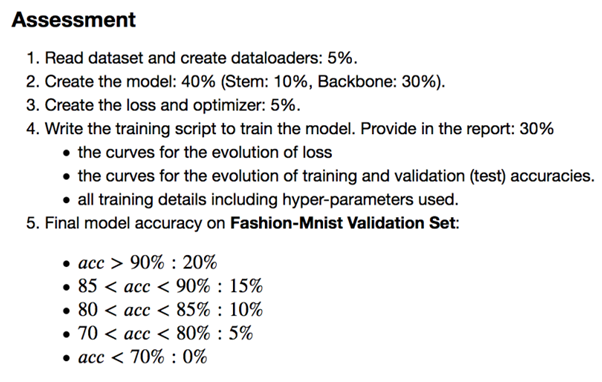

# Imports

In [5]:
# Setting up google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [6]:
import my_utils as mu
import torch
import helper
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from IPython import display
from tqdm.notebook import trange, tqdm

import copy
import random
import time

# Load Data

In [7]:
# during dev, using batch size of 100 images
batch_size = 256
trainset, testset = mu.load_data_fashion_mnist(batch_size)

trainset

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The Stem

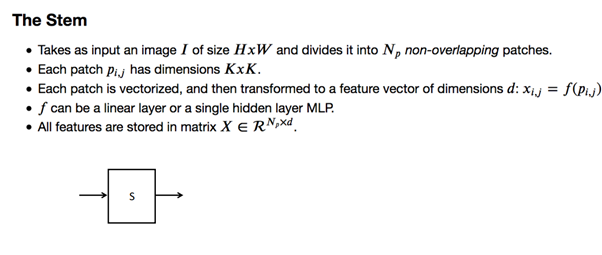

In [8]:
image, label = next(iter(trainset))

# Take input of image I of size HxW (images from Fashion MNist are 28x28) and convert to 4 x (14x14)
def stem(image):
  # Divide into Np patches of dimension KxK (i.e. 4 patches of 14x14)
  kc, kh, kw = 1, 14, 14
  dc, dh, dw = 14, 14, 14

  patches = image.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
  unfold_shape = patches.size()
  patches.contiguous().view(-1, kc, kh, kw)

  return np.reshape(patches, (4,196))

# x = stem(image)

# print(x)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The Backbone

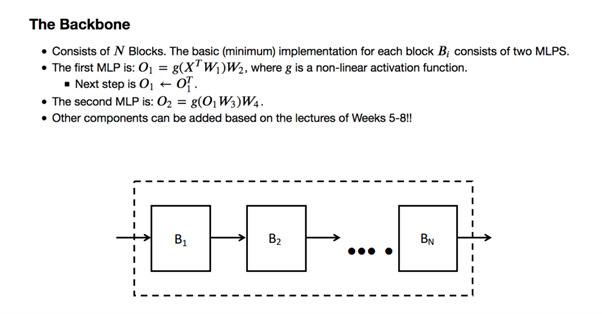

In [9]:
class Net(nn.Module):
  def __init__(self, inputs=784, outputs=10, hidden_layers=[128,64,32]):
    super().__init__()

    #Building the backbone of the model:
    self.linear1 = nn.Linear(inputs, hidden_layers[0]) #MLP1 input layer
    self.linear2 = nn.Linear(hidden_layers[0], hidden_layers[0]) #MLP1

    self.linear3 = nn.Linear(hidden_layers[0], hidden_layers[1]) #MLP2 input layer
    self.linear4 = nn.Linear(hidden_layers[1], outputs) #MLP2

  #initializing the weights and the bias for each linear layer
    torch.nn.init.normal_(self.linear1.weight, std=0.01)
    torch.nn.init.zeros_(self.linear1.bias)

    torch.nn.init.normal_(self.linear2.weight, std=0.01)
    torch.nn.init.zeros_(self.linear2.bias)

    torch.nn.init.normal_(self.linear3.weight, std=0.01)
    torch.nn.init.zeros_(self.linear3.bias)


  def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # Apply activation function - ReLU to the first MLP -> g(XtW1)
        h_1 = F.relu(self.linear1(x)) 
        # Apply just the linear2 function to get: g(XtW1)W2 == h_1*W2
        h_2 = self.linear2(h_1) 
        # Apply activation function - ReLU to the second MLP -> g(O1W3)
        h_3 = F.relu(self.linear3(h_2))  
        # Apply just the linear4 function to get: g(O1W3)W4 == h_3*W4
        y_pred = self.linear4(h_3) 

   #softmax regression classifier here?

        return y_pred, h_3


#Creating an instance of the model using:
  # the number of inputs (size of a patch = 784 #i.e 28*28*1), 
  # number of outputs (10 classes) 
  # and the hidden layers (2 MLP layers = [128,64,32]).
model = Net(inputs=784, outputs=10, hidden_layers=[128, 64, 32])  #Todo: change the num_inputs and layers to reflect the patches sizes.
print(model)

criterion = nn.CrossEntropyLoss()
optimiser = Adam(model.parameters())

Net(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [10]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [11]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        # vectorise + stem
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
EPOCHS = 10

best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, trainset, optimiser, criterion, device)
    valid_loss, valid_acc = evaluate(model, testset, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.883 | Train Acc: 66.51%
	 Val. Loss: 0.632 |  Val. Acc: 77.15%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.530 | Train Acc: 81.22%
	 Val. Loss: 0.519 |  Val. Acc: 81.75%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.462 | Train Acc: 83.68%
	 Val. Loss: 0.467 |  Val. Acc: 83.16%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.413 | Train Acc: 85.27%
	 Val. Loss: 0.433 |  Val. Acc: 84.39%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.385 | Train Acc: 86.14%
	 Val. Loss: 0.415 |  Val. Acc: 85.13%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.367 | Train Acc: 86.73%
	 Val. Loss: 0.393 |  Val. Acc: 85.68%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.352 | Train Acc: 87.14%
	 Val. Loss: 0.386 |  Val. Acc: 85.80%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 7s
	Train Loss: 0.332 | Train Acc: 87.87%
	 Val. Loss: 0.381 |  Val. Acc: 86.51%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.323 | Train Acc: 88.20%
	 Val. Loss: 0.379 |  Val. Acc: 85.98%


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.313 | Train Acc: 88.54%
	 Val. Loss: 0.366 |  Val. Acc: 86.70%


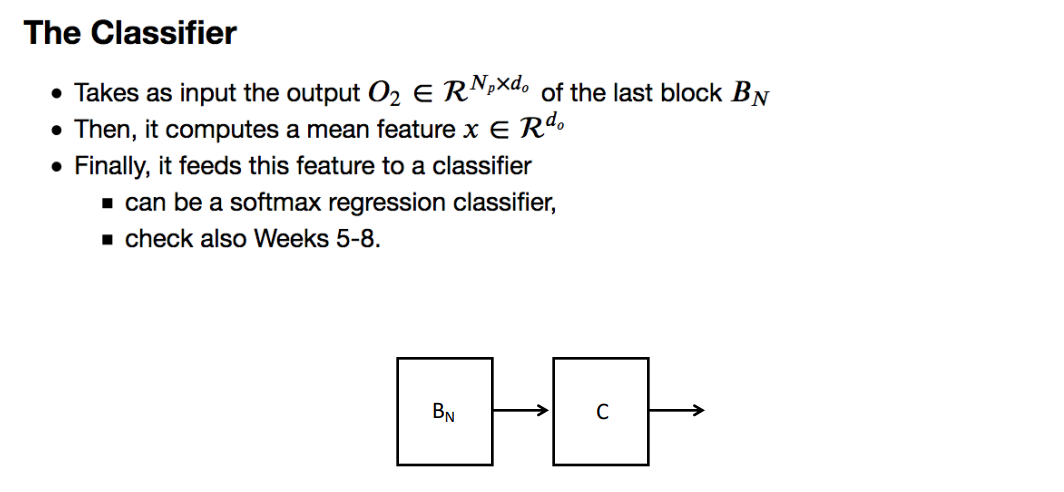